In [59]:
#추가되는 패키지
#추자면 날씨 크롤링
import requests
from bs4 import BeautifulSoup

In [245]:
# 데이터 load
train = pd.read_csv('train.csv',date_parser='date')
train.tail()

id        date  bus_route_id in_out  station_code  station_name  \
415418  415418  2019-09-30      32820000     시내          1129  한림환승정류장(한림리)   
415419  415419  2019-09-30      32820000     시내          1564     제주시외버스터미널   
415420  415420  2019-09-30      32820000     시내          2322          해병부대   
415421  415421  2019-09-30      32820000     시내          3291  애월환승정류장(애월리)   
415422  415422  2019-09-30      32820000     시내       6115100    서귀포시외버스터미널   

        latitude  longitude  6~7_ride  7~8_ride  ...  9~10_ride  10~11_ride  \
415418  33.41437  126.26336       4.0       0.0  ...        0.0         0.0   
415419  33.49946  126.51479       4.0       0.0  ...        0.0         0.0   
415420  33.23100  126.26273       0.0       0.0  ...        0.0         0.0   
415421  33.46483  126.31870       1.0       0.0  ...        0.0         0.0   
415422  33.24873  126.50799       0.0       0.0  ...        0.0         0.0   

        11~12_ride  6~7_takeoff  7~8_takeoff  8~9_takeoff  9~10_takeoff  \
415418         0.0          0.0          0.0          0.0           0.0   
415419         0.0          0.0          0.0          0.0           0.0   
415420         0.0          0.0          1.0          0.0           0.0   
415421         0.0          0.0          0.0          0.0           0.0   
415422         0.0          0.0          0.0          4.0           0.0   

        10~11_takeoff  11~12_takeoff  18~20_ride  
415418            0.0            0.0         0.0  
415419            0.0            0.0         0.0  
415420            0.0            0.0         0.0  
415421            0.0            0.0         0.0  
415422            0.0            0.0         0.0  

[5 rows x 21 columns]

# 이전 변수(요일,주말여부,추석여부,위치) + 컬럼명수정

In [246]:
#weekday
train['date'] = pd.to_datetime(train['date'])
train['weekday'] = train['date'].dt.weekday

In [247]:
#weekend
train['weekend']=[1 if date>=5 else 0 for date in train['weekday']]
train.weekend.unique()

array([1, 0], dtype=int64)

In [248]:
#Thanksgiving_Day
train['Thanksgiving_Day'] = 0
train.loc[train['date'] == '2019-09-14', 'Thanksgiving_Day'] = 1
train.loc[train['date'] == '2019-09-13', 'Thanksgiving_Day'] = 1
train.loc[train['date'] == '2019-09-12', 'Thanksgiving_Day'] = 1

In [249]:
#위치
jeju_addr=pd.read_csv('jeju_addr.csv')
train = pd.merge(train, jeju_addr, on= 'station_code')
train.tail(2)

id       date  bus_route_id in_out  station_code station_name  \
415421  400433 2019-09-30      22210000     시내          1585       셰프라인월드   
415422  406662 2019-09-30      27180000     시내          3552        행원교차로   

        latitude  longitude  6~7_ride  7~8_ride  ...  11~12_takeoff  \
415421  33.43489  126.73242       0.0       1.0  ...            0.0   
415422  33.54574  126.80370       0.0       0.0  ...            0.0   

        18~20_ride  weekday  weekend  Thanksgiving_Day  \
415421         0.0        0        0                 0   
415422         0.0        0        0                 0   

                              지번주소   si  city  dong  road_addr  
415421  제주특별자치도 제주시 구좌읍 송당리 2635-3  제주시   구좌읍   송당리       비자림로  
415422  제주특별자치도 제주시 구좌읍 행원리 1180-3  제주시   구좌읍   행원리       일주동로  

[2 rows x 29 columns]

In [250]:
# 1시간 단위 컬럼명 수정
train.rename(columns={'6~7_ride': 'ride6', '7~8_ride': 'ride7', '8~9_ride': 'ride8',\
                      '9~10_ride': 'ride9', '10~11_ride': 'ride10', '11~12_ride': 'ride11', 
                      '6~7_takeoff': 'off6', '7~8_takeoff': 'off7', '8~9_takeoff': 'off8', \
                      '9~10_takeoff': 'off9', '10~11_takeoff': 'off10', '11~12_takeoff': 'off11',\
                      '18~20_ride': 'ride18'},inplace=True)

# 2시간 단위 컬럼 생성
train['ride68']=train['ride6']+train['ride7'] # 6 ~ 8시 승차인원
train['ride810']=train['ride8']+train['ride9']
train['ride1012']=train['ride10']+train['ride11']

train['off68']=train['off6']+train['off7'] # 6 ~ 8시 하차인원
train['off810']=train['off8']+train['off9']
train['off1012']=train['off10']+train['off11']

## 3시간 단위로 컬럼명 수정
#train['ride69']=train['ride6']+train['ride7']+train['ride8'] # 6 ~ 9시 승차인원
#train['ride912']=train['ride9']+train['ride10']+train['ride11']
#
#train['off69']=train['off6']+train['off7']+train['off8'] # 6 ~ 9시 하차인원
#train['off912']=train['off9']+train['off10']+train['off11']

# 날씨

### EDA
- 과연 세부 날씨를 나누는 것이 의미 있는가?

In [251]:
weather=pd.read_excel('all_weather.xlsx')
weather.tail(2)

weather_addr       date  temperature  precipitation
148           추자 2019-09-29         24.1            0.0
149           추자 2019-09-30         24.5            0.0

In [252]:
jeju=weather[weather.weather_addr=='제주']
seogipo=weather[weather.weather_addr=='서귀포']
sungsan=weather[weather.weather_addr=='성산']
gosan=weather[weather.weather_addr=='고산']
chuga=weather[weather.weather_addr=='추자']

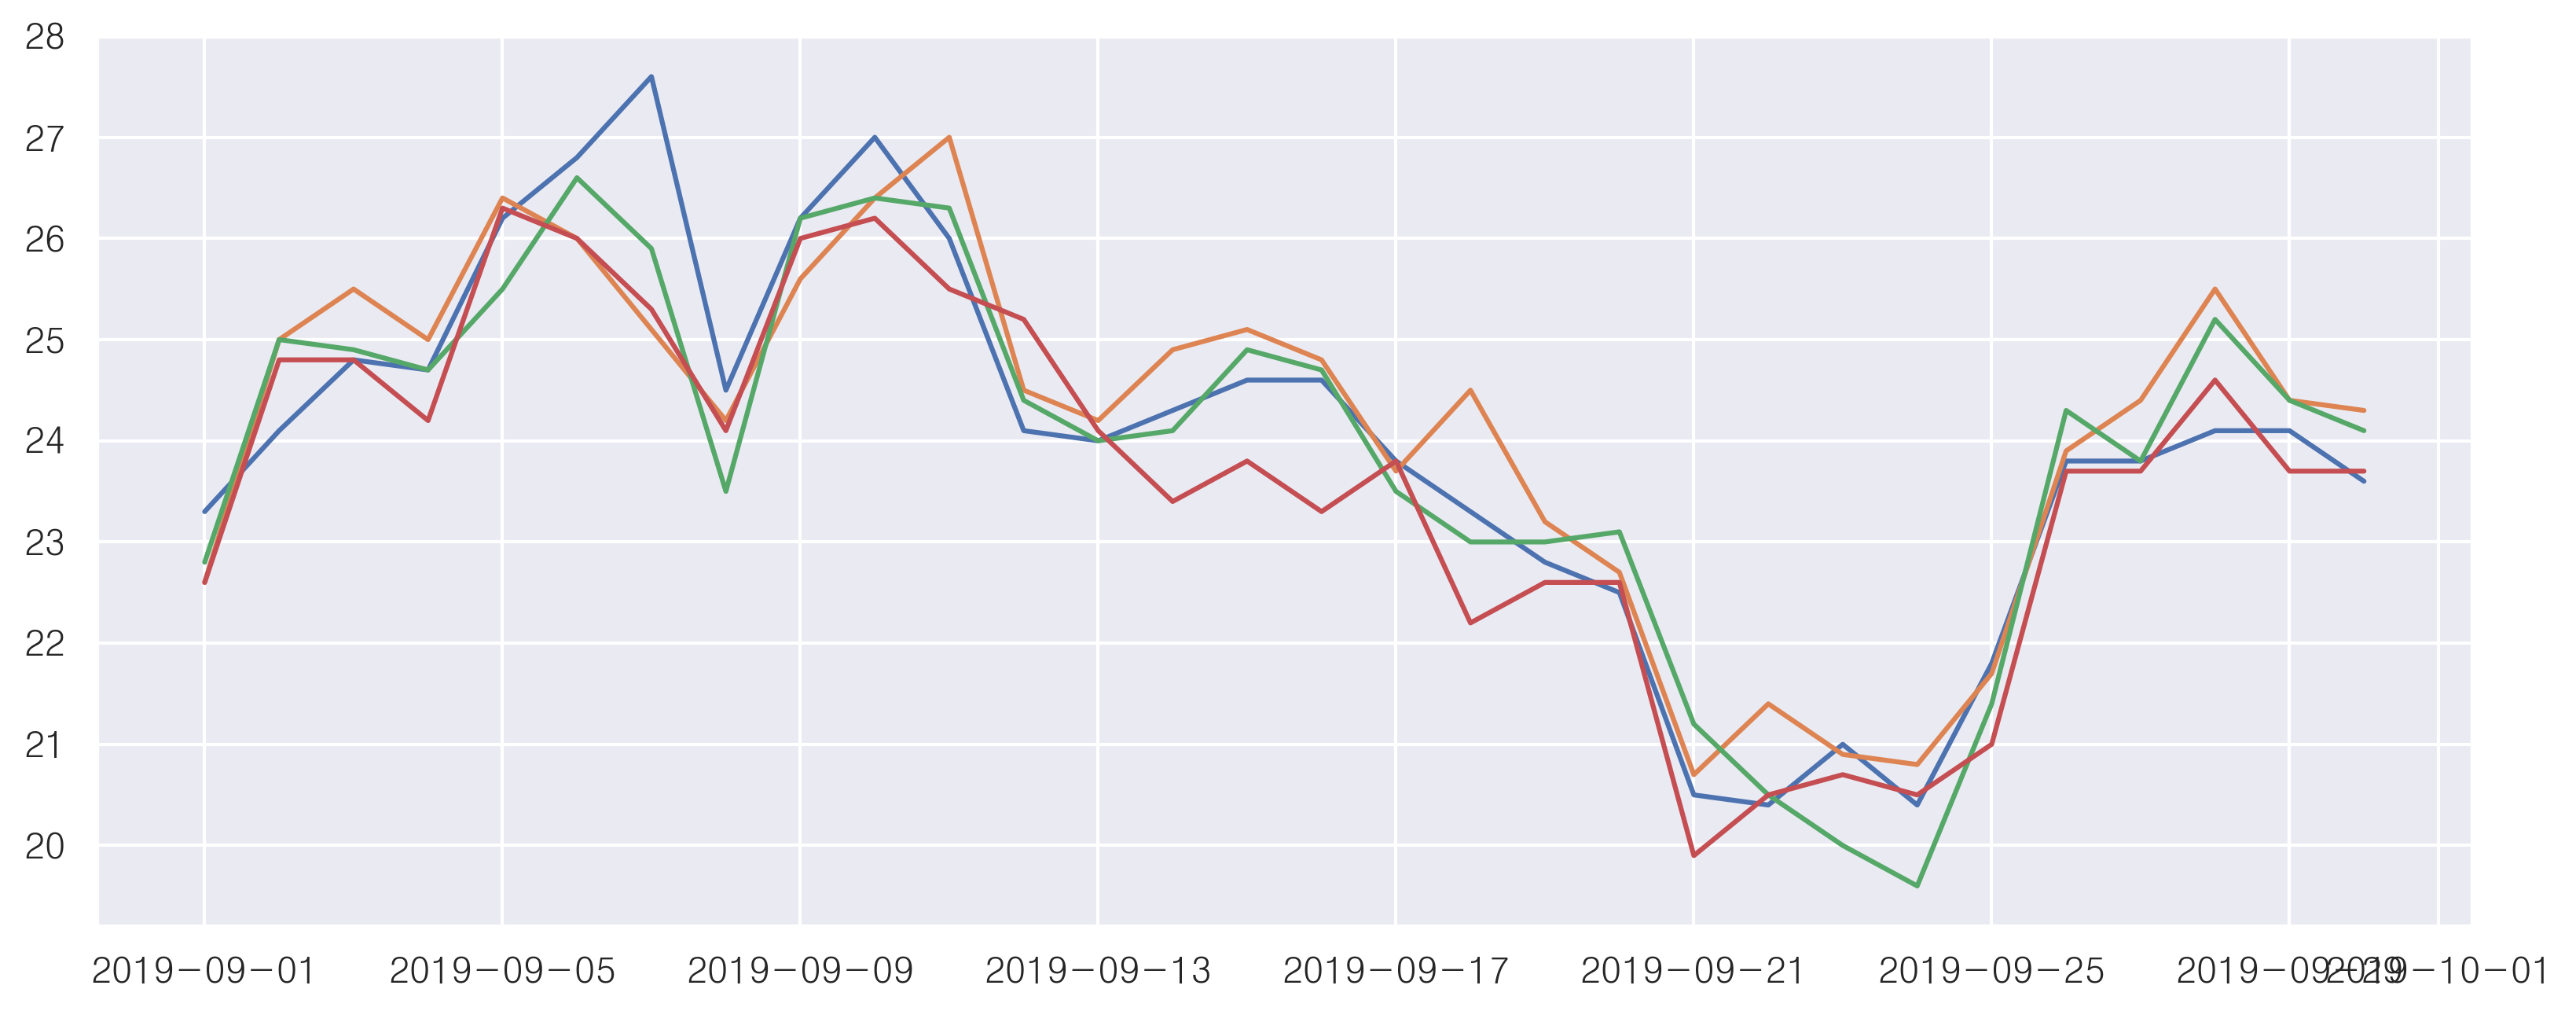

In [253]:
#평균기온
plt.figure(figsize=(13,5))
plt.plot(jeju['date'],jeju['temperature'])
plt.plot(seogipo['date'],seogipo['temperature'])
plt.plot(sungsan['date'],sungsan['temperature'])
plt.plot(gosan['date'],gosan['temperature'])

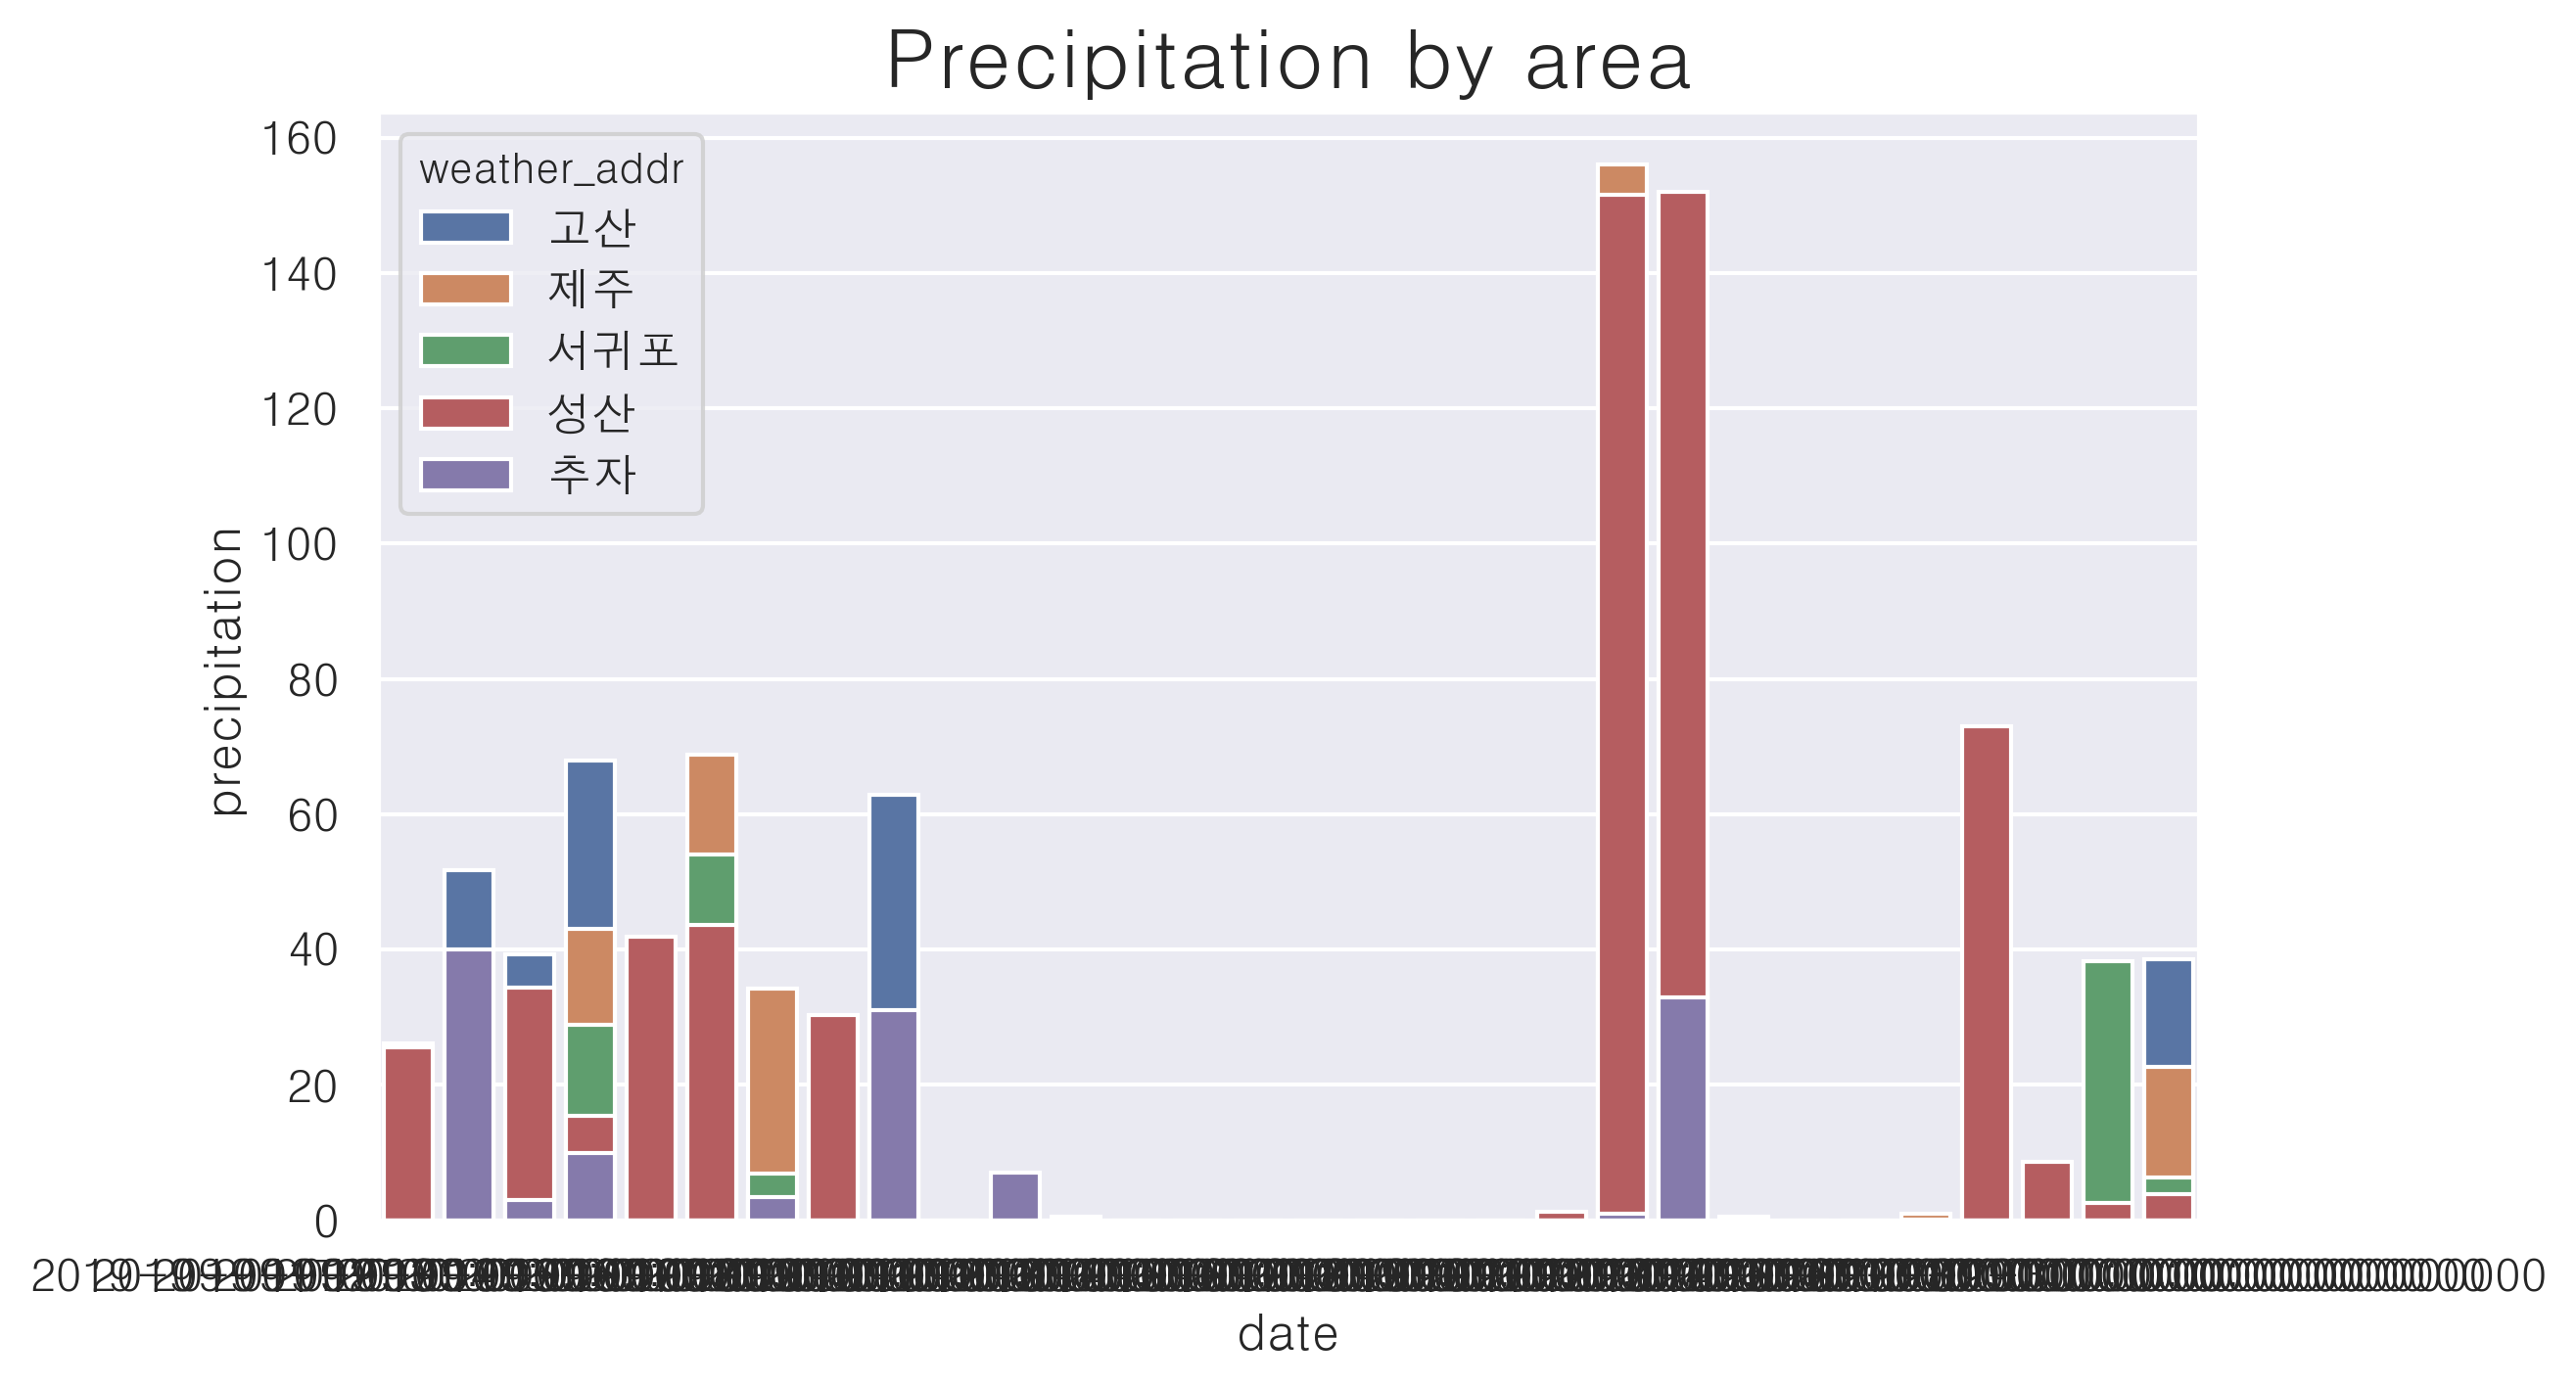

In [254]:
#강수량-> 지역별 차이가 있는 날짜가 존재함
sns.barplot(x='date', y='precipitation', hue='weather_addr',data=weather,dodge=False) # stacked bar chart
plt.title('Precipitation by area', fontsize='20')
plt.show()

지역별 강수량의 차이가 있어 보이므로 지역을 세부적으로 분리하는 것이 의미있어 보임

### 크롤링
- 추자면의 날씨는 따로 제공되지 않아 개별적으로 크롤링함

- 아래는 크롤링 코드이니 실행시키지 마세요!!

--------------

In [203]:
#9월 추자면의 평균기온,강수량 크롤링함수

def chuga(date): 
    response=requests.get('https://www.weather.go.kr/cgi-bin/aws/nph-aws_txt_min_guide_test?201909{}1000&0&MINDB_01M&4184&m&K'.format(date))
    dom = BeautifulSoup(response.content, "html.parser")
    #날짜
    dt='2019-09-{}'.format(date)
    #기온
    temp=dom.select('body > p > table:nth-child(23) >tr > td > table > tr.text > td:nth-child(11)')
    temp=temp[0].text
    #강수량
    rain=dom.select('body > p > table:nth-child(23)> tr> td > table> tr.text > td:nth-child(10)')
    rain=rain[0].text
    return dt,temp,rain

In [228]:
#9월01~9월30일 추자면 날씨 크롤링 후 csv로 저장
date=['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20',\
      '21','22','23','24','25','26','27','28','29','30']
result=[]
for date in date:
    result.append(chuga(date))
chuga_weather=pd.DataFrame(result,columns=['date','mean temperature','precipitation'])
chuga_weather.to_csv("chuga_weather.csv", mode='w')
chuga_weather.tail()

date mean temperature precipitation
25  2019-09-26             22.1             0
26  2019-09-27             23.7             0
27  2019-09-28             22.7             0
28  2019-09-29             24.1             0
29  2019-09-30             24.5             0

----------------

In [255]:
#제주 : 제주시,애월읍,조천읍
#서귀포: 서귀포시,남원읍,안덕면
#성산: 성산읍,구좌읍,우도면,표선면
#고산 :한경면,한림읍,대정읍
#추자 : 추자면

In [256]:
#weather 데이터를 추가하기 전 실행해주세요!
jeju=['제주시','애월읍','조천읍']
seogipo=['서귀포시','남원읍','안덕면']
sungsan=['성산읍','구좌읍','우도면','표선면']
gosan=['한경면','한림읍','대정읍']
chuga=['추자면']
weather_addr=[]
for city in train['city']:
    if city in jeju: weather_addr.append('제주')
    elif city in seogipo: weather_addr.append('서귀포')
    elif city in gosan : weather_addr.append('고산')
    elif city in sungsan : weather_addr.append('성산')
    elif city in chuga : weather_addr.append('추자')    
#weather_addr 컬럼 생성
train['weather_addr']=weather_addr

In [257]:
#weather 변수 추가
weather=pd.read_excel('all_weather.xlsx')
train = pd.merge(train, weather, on= ['weather_addr','date'])
train.tail(2)

id       date  bus_route_id in_out  station_code station_name  \
415421  294340 2019-09-22      31590000     시내          2740       하모체육공원   
415422  292357 2019-09-22      27700000     시내          4122          붉으내   

        latitude  longitude  ride6  ride7  ...  road_addr  ride68  ride810  \
415421  33.21875  126.25229    0.0    0.0  ...     최남단해안로     0.0      0.0   
415422  33.31893  126.17250    1.0    0.0  ...      한경해안로     1.0      0.0   

        ride1012  off68  off810  off1012  weather_addr  temperature  \
415421       0.0    0.0     0.0      1.0            고산         20.5   
415422       0.0    0.0     0.0      0.0            고산         20.5   

        precipitation  
415421           34.1  
415422           34.1  

[2 rows x 38 columns]

# 배차간격

### 크롤링
- 아래의 코드는 매우 오래걸리므로 실행시키지 마세요! 발표를 위해 코드 공유드림. 이미 공유드린 bus_interval만 merge 시켜주시면 됩니다.
******

In [ ]:
train['bus_route_id'] = train['bus_route_id'].astype(np.int64)
test['bus_route_id'] = test['bus_route_id'].astype(np.int64)

In [ ]:
bts['geton_time2'] = pd.to_datetime(bts['geton_time'])

f = bts.groupby(['geton_date','geton_time2','geton_station_code','bus_route_id'])['user_count'].\
agg([('탑승객_수','sum')]).reset_index().\
sort_values(by=['geton_date','geton_station_code','bus_route_id','geton_time2'], ascending=True).reset_index()

f['index'] = list(range(0,len(f)))

In [ ]:
time = []

for i in range(0,len(f)-1):

    if ((f.iloc[i].geton_date == f.iloc[i+1].geton_date) &\
        (f.iloc[i].geton_station_code == f.iloc[i+1].geton_station_code) &\
        (f.iloc[i].bus_route_id == f.iloc[i+1].bus_route_id)):

        time.append(f.iloc[i+1].geton_time2 - f.iloc[i].geton_time2)

    else:
        time.append(0)

time.insert(0, '0')

In [ ]:
def get_sec(time_str):

    h, m, s = time_str.split(':')

    return int(h) * 3600 + int(m) * 60 + int(s)

In [ ]:
def bus_interval() :

    f['time'] = time
    f['time2'] = f['time'].astype(str).str[7:]


    interval = f.copy()
    interval['time2'] = interval['time2'].astype(str).replace('','00:00:00')
    interval['bus_route_id'] = interval['bus_route_id'].astype(object)

    time4 = []

    for i in interval['time2'] :

        time4.append(get_sec(i))

    interval['time4'] = time4
    interval['time4'] = (interval['time4'] / 60).astype(int)

    interval = interval[interval['time4'] &gt; 3] # 간격이 3분보다 작은 것 제외 
    interval = interval[interval['time4'] &lt; 180] # 간격이 3시간보다 큰 것 제외

    interval = interval.groupby('bus_route_id')['time4'].agg([('bus_interval', 'mean')]).reset_index()
    interval['bus_interval'] = interval['bus_interval'].astype(int)

    # 나중에 시간을 절약하기 위해 csv 파일로 저장
    interval.to_csv('bus_interval_final.csv', index = False)

    print('success.. !')

In [ ]:
bus_interval()

******

아래의 코드만 실행시켜주세요!

In [258]:
#bus_interval 변수 추가
bus_interval=pd.read_csv('bus_interval_final.csv')
train = pd.merge(train, bus_interval, on='bus_route_id',how='left')
train[train['bus_interval'].isnull()]=bus_interval['bus_interval'].mean()
train.tail(2)

id       date  bus_route_id in_out  station_code station_name  \
391858  49011 2019-09-04      27600000     시내          2445       대정초교후문   
391859  49012 2019-09-04      27600000     시내          2832          방아동   

        latitude  longitude  ride6  ride7  ...  ride68  ride810  ride1012  \
391858  33.22557  126.25638    0.0    0.0  ...     0.0      0.0       0.0   
391859  33.27974  126.17505    0.0    0.0  ...     0.0      0.0       0.0   

        off68  off810  off1012  weather_addr  temperature  precipitation  \
391858    0.0     1.0      3.0            고산         24.2           67.9   
391859    0.0     1.0      0.0            고산         24.2           67.9   

        bus_interval  
391858            86  
391859            86  

[2 rows x 39 columns]